# ImageNetの犬画像で犬種を判別する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataloader import Dataloader
from solver import Solver

Using TensorFlow backend.


In [2]:
# tensorflow GPU用の設定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# データのダウンロード

In [3]:
dataloader_ins = Dataloader()

resize_shape = (255, 255)
dataloader_ins.get_user_data(train_dir='/data/dog_imagenet/train', batch_size=10,
                             validation_dir='/data/dog_imagenet/test',
                             resize_shape=resize_shape,
                             test_dir='/data/dog_imagenet/test', test_batch_size=1)

Found 11687 images belonging to 17 classes.
Found 1291 images belonging to 17 classes.
Found 1291 images belonging to 17 classes.


In [22]:
indeces_to_labels = {i: label for label, i in dataloader_ins.train_generator.class_indices.items()}
indeces_to_labels

{0: 'Chihuahua',
 1: 'Doberman',
 2: 'German shepherd',
 3: 'Labrador retriever',
 4: 'Pomeranian',
 5: 'Siberian husky',
 6: 'Yorkshire terrier',
 7: 'beagle',
 8: 'bulldog',
 9: 'collie',
 10: 'corgi',
 11: 'dalmatian',
 12: 'golden retriever',
 13: 'pug',
 14: 'schnauzer',
 15: 'standard poodle',
 16: 'toy poodle'}

Text(0.5, 1.0, 'ans=Yorkshire terrier')

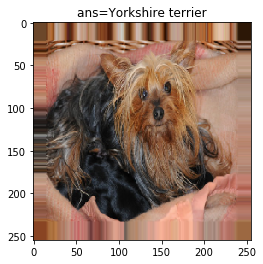

In [43]:
# 訓練データの表示
x_train, y_train = next(dataloader_ins.train_generator)
x_train, y_train = x_train[0], y_train[0]  # 1枚だけ画像を取得
i_label = y_train.argmax() # one-hotから答えのラベルを取得
ans = indeces_to_labels[i_label]

plt.imshow(x_train)
plt.title('ans=' + ans)

# モデルの定義

In [6]:
!pip install -U efficientnet==0.0.4
from usermodel_efficientnet import Usermodel_efficientnet

  Created wheel for efficientnet: filename=efficientnet-0.0.4-py3-none-any.whl size=17048 sha256=9db3f3d220ce43e4401378b4e1514949b349b2cae647d631e6857310833308a8
  Stored in directory: /root/.cache/pip/wheels/48/77/65/e498764afaec783b7ca559ee765d2b1099efc59af24fdd73aa
Successfully built efficientnet


In [7]:
# EfficinetNet
category = len(indeces_to_labels)  # カテゴリ数
usermodel_ins = Usermodel_efficientnet(cut_size={'height': resize_shape[0], 'width': resize_shape[1]}, channel=3, category_count=category)

# 学習

In [8]:
solver_ins = Solver(dataloader_ins, usermodel_ins, n_epochs=10)

In [9]:
model = solver_ins.get_model()

input_shape : (255, 255, 3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
16719872/16717576 [==============================] - 4s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
solver_ins.train_generator(model)


Epoch 1/10
1169/1169 [==============================] - 374s 320ms/step - loss: 0.1112 - categorical_accuracy: 0.6553 - val_loss: 0.0048 - val_categorical_accuracy: 0.6948
Epoch 2/10
1169/1169 [==============================] - 211s 180ms/step - loss: 0.0832 - categorical_accuracy: 0.7371 - val_loss: 2.7400e-06 - val_categorical_accuracy: 0.7816
Epoch 3/10
1169/1169 [==============================] - 213s 182ms/step - loss: 0.0709 - categorical_accuracy: 0.7800 - val_loss: 0.0038 - val_categorical_accuracy: 0.7436
Epoch 4/10
1169/1169 [==============================] - 212s 182ms/step - loss: 0.0641 - categorical_accuracy: 0.8046 - val_loss: 0.0512 - val_categorical_accuracy: 0.7467
Epoch 5/10
1169/1169 [==============================] - 212s 181ms/step - loss: 0.0581 - categorical_accuracy: 0.8237 - val_loss: 0.0093 - val_categorical_accuracy: 0.7800
Epoch 6/10
1169/1169 [==============================] - 211s 181ms/step - loss: 0.0533 - categorical_accuracy: 0.8370 - val_loss: 2.997

# 結果

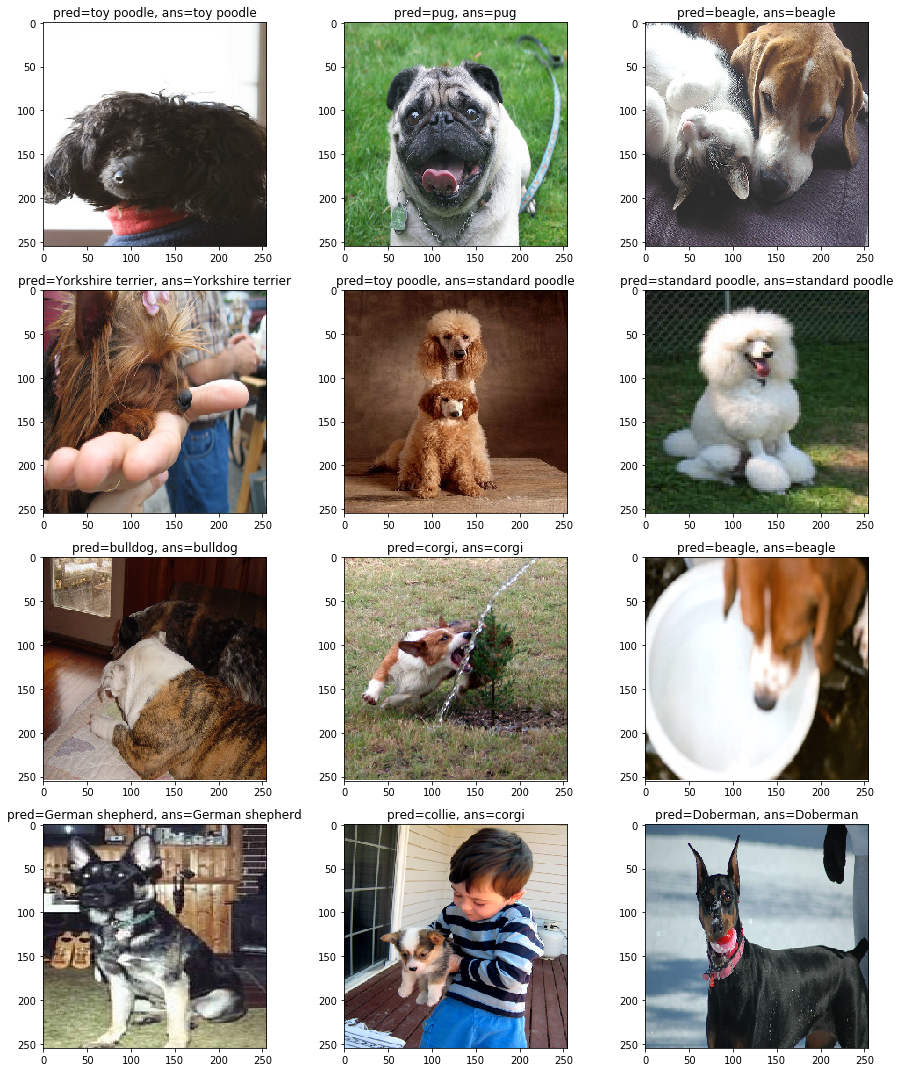

In [57]:
# テストデータの予測結果を表示
plt.figure(figsize=(13, 15))
for i in range(12):
    plt.subplot(4, 3, i+1)
    x_test, y_test = next(dataloader_ins.test_generator)
    pred = model.predict(x_test) # 予測
    i_pred_label = pred.argmax()  # one-hotから予測したラベルを取得
    pred_label = indeces_to_labels[i_pred_label]

    x_test, y_test = x_test[0], y_test[0]  # 0番目の次元を削る
    i_label = y_test.argmax() # one-hotから答えのラベルを取得
    ans = indeces_to_labels[i_label]

    plt.imshow(x_test)
    plt.title('pred=' + pred_label + ', ans=' + ans)
plt.tight_layout()

# CAM

In [58]:
from class_activation_map import ClassActivationMap

In [59]:
# ClassActivationMap計算用クラスの作成
cam = ClassActivationMap(model, layer_GAP=-2, layer_dense=-1)

In [75]:
# CAMを計算したい画像
x_test, y_test = next(dataloader_ins.test_generator)

In [76]:
# ClassActivationMapを計算
cam_images = cam.get_class_activation_map(x_test)
cam_images.shape

(1, 8, 8, 17)

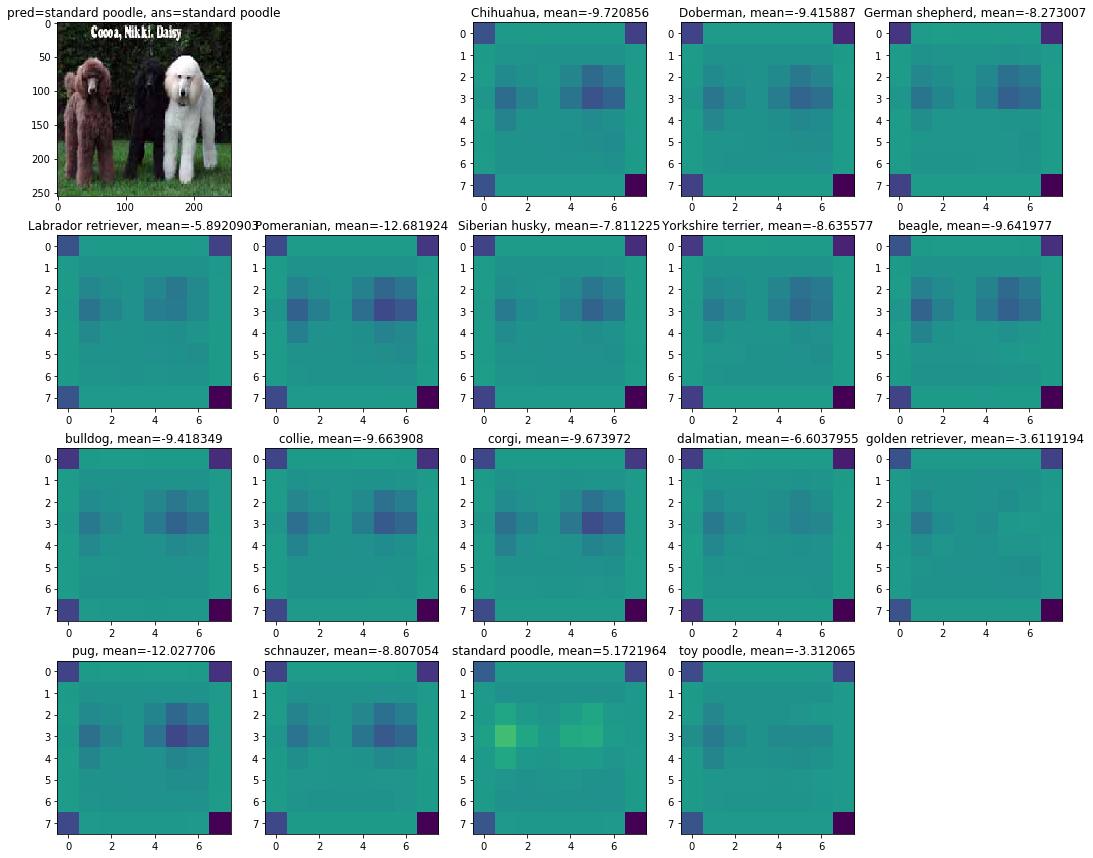

In [85]:
# 図示する画像を一枚だけ選ぶ
i = 0
image = x_test[i]
label = y_test[i]
cam_image = cam_images[i]

# 予測結果と答えを計算
i_pred_label = model.predict(image[np.newaxis, :, :, :]).argmax()  # 予測結果
pred_label = indeces_to_labels[i_pred_label]
i_label = label.argmax()  # 答え
ans = indeces_to_labels[i_label]

### 図示 ###
plt.figure(figsize=(18, 15))
# 元画像
plt.subplot(451)
plt.imshow(image)
plt.title('pred={0}, ans={1}'.format(pred_label, ans))
# CAM
for j, l in indeces_to_labels.items():
    cam_class = cam_image[:, :, j]  # あるクラスのCAMを取得
    plt.subplot(4, 5, j+3)
    plt.imshow(cam_class, vmin=-200, vmax=200)
    plt.title(l + ', mean=' + str(cam_class.mean()))  # あるクラスのCAMの平均